In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.initializers as initializers
import matplotlib.pyplot as plt
from matplotlib import rc


def numToBitArray(i, n):
    result = np.zeros(n, dtype=int)
    for j in range(n):
        result[j] = i & 1
        i = i >> 1
    return result


def genData(n):
    result = np.zeros((2**(2 * (n)), 2, n), dtype=int)
    for i in range(2**(n)):
        for j in range(2**n):
            result[i * (2**n) + j][0] = numToBitArray(i, n)
            result[i * (2**n) + j][1] = numToBitArray(j, n)

    return result


def genTeachSignal(inputData):
    result = np.zeros(inputData.shape[0], dtype=int)
    for i in range(inputData.shape[0]):
        result[i] = np.dot(inputData[i][0], inputData[i][1]) % 2

    return result


zeroToMinusOne = np.array([-1, 1])


def train_network(n_hidden, input_dimension):
    """
    Trains a neural network and returns the lowest error.
    :param input_dimension: length of x and y vector
    :param n_hidden: Number of hidden neurons to use per
    layer (as vector to indicate when multiple hidden
    layers should be used). For example, [2] uses one
    hidden layer with two neurons and [2, 2] uses two
    hidden layers each with two neurons.
    :return: The lowest error (MSE) occurred over all
    training epochs.
    """

    # Start fresh and at least try to get reproducible results
    tf.reset_default_graph()
    K.clear_session()
    tf.set_random_seed(42)
    np.random.seed(42)

    activation_function = 'tanh'
    initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5)
    model = Sequential()

    # Add hidden layers
    for i in range(len(n_hidden)):
        if i == 0:
            # Specify input dimension on first layer
            model.add(
                Dense(
                    n_hidden[0],
                    input_dim=2 * input_dimension,
                    kernel_initializer=initializer,
                    activation=activation_function))
        else:
            model.add(
                Dense(
                    n_hidden[i],
                    kernel_initializer=initializer,
                    activation=activation_function))

    # Add output layer
    model.add(Dense(1))

    model.compile(
        optimizer=optimizers.SGD(
            lr=0.2, decay=0.0001, momentum=0.9, nesterov=True),
        loss='mse')

    training_data = zeroToMinusOne[genData(input_dimension)].reshape(
        -1, 2 * input_dimension)
    teaching_data = zeroToMinusOne[genTeachSignal(genData(input_dimension))]

    history = model.fit(training_data, teaching_data, epochs=300, verbose=0)
    return np.amin(history.history["loss"])


n = 3

# Train flat networks with different number of neurons in hidden layer
nrNeuronsFlat = np.zeros(2**n + 4)
flatResults = np.zeros(2**n + 4)
for i in range(2**n + 4):
    flatResults[i] = train_network([i + 1], n)
    nrNeuronsFlat[i] = i + 2

# Train deep networks with different number of neurons in 2 hidden layers
nrNeuronsDeep = np.zeros(n + 4)
deepResults = np.zeros(n + 4)
for i in range(n + 4):
    deepResults[i] = train_network([i + 1, i + 1], n)
    nrNeuronsDeep[i] = 2 * (i + 1) + 1

W0624 19:51:59.666113 140674415257408 deprecation.py:506] From /projects/3fc4284d-5ed1-41d2-bdfc-0f9a1167298f/.local/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0624 19:51:59.697954 140674415257408 deprecation.py:506] From /projects/3fc4284d-5ed1-41d2-bdfc-0f9a1167298f/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


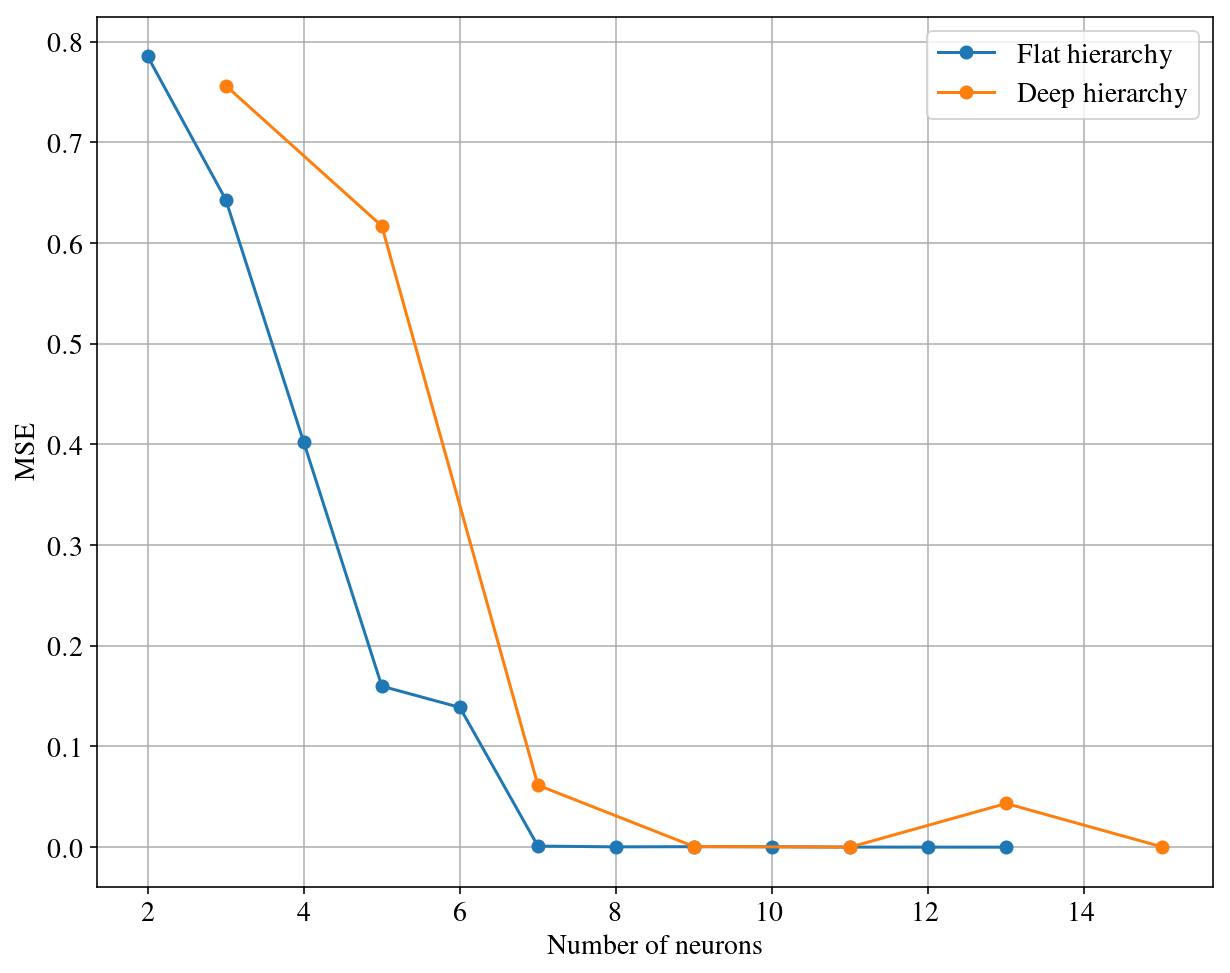

In [2]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(nrNeuronsFlat, flatResults, label="Flat hierarchy", marker="o")
plt.plot(nrNeuronsDeep, deepResults, label="Deep hierarchy", marker="o")
plt.xlabel("Number of neurons")
plt.ylabel("MSE")
plt.grid()
plt.legend()